# Autocorrelation and Autoregression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('seaborn-darkgrid')

In [2]:
shampoo = pd.read_excel('data/ShampooSales.xls')

In [3]:
shampoo.head()

,Month,Shampoo Sales
0,1995-01-01,266.0
1,1995-02-01,145.9
2,1995-03-01,183.1
3,1995-04-01,119.3
4,1995-05-01,180.3


In [5]:
shampoo.info()

# date is already set to a datetime64, no need to convert

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Month          36 non-null     datetime64[ns]
 1   Shampoo Sales  36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 704.0 bytes


In [6]:
shampoo.set_index('Month', inplace = True)

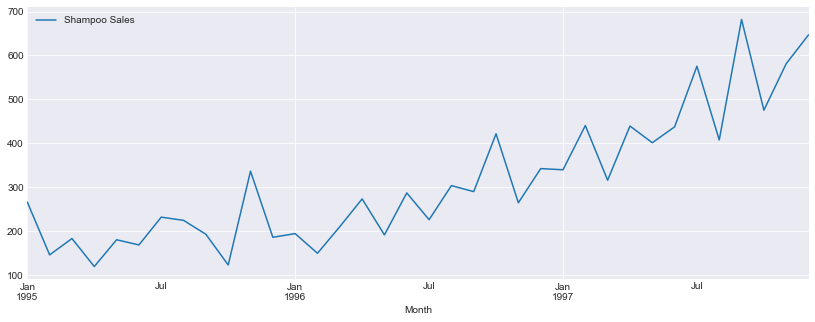

In [7]:
shampoo.plot(figsize = (14, 5))

### Is it stationary?

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
adfuller(shampoo['Shampoo Sales'])[1]

1.0

In [10]:
adfuller(shampoo['Shampoo Sales'].diff(1).dropna())[1]

1.7998574141686703e-10

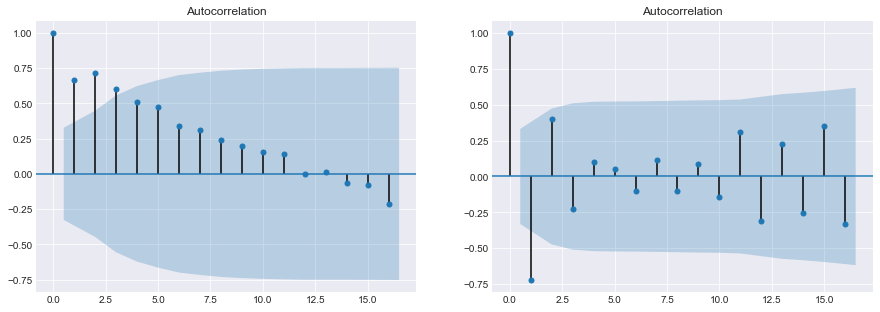

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
plot_acf(shampoo['Shampoo Sales'], ax = ax[0]);
plot_acf(shampoo['Shampoo Sales'].diff(1).dropna(), ax = ax[1]);

### Autoregression

$$X_{t}=c+\varphi X_{{t-1}}+\varepsilon _{t}$$

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from statsmodels.tsa.arima_model import ARIMA

### Train/Test Split

![](ttest.png)

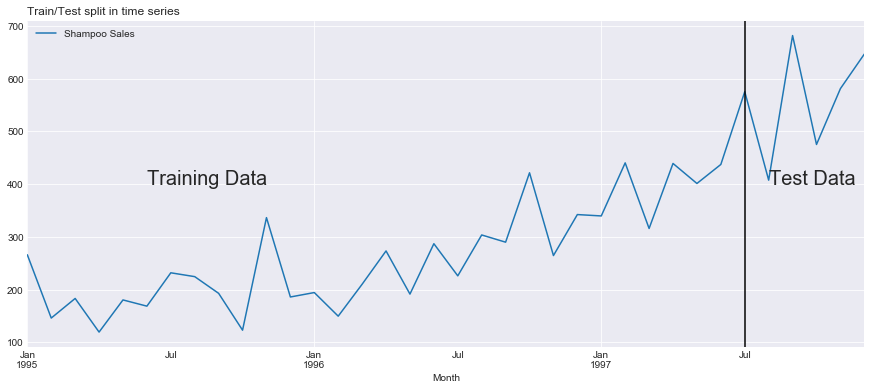

In [13]:
shampoo.plot(figsize = (15, 6))
plt.axvline('1997-07-01', color = 'black')
plt.text('1995-06-01', 400, 'Training Data', fontsize = 20)
plt.text('1997-08-01', 400, 'Test Data', fontsize = 20)
plt.title('Train/Test split in time series', loc = 'left')
plt.savefig('ttest.png')

In [14]:
#split data by time
train = shampoo[:-5] 
test = shampoo[-5:] # last five obs as the test data

In [16]:
#build AR model on dataset diffed by 1, using one previous term
#in autoregression specified by order
ar = ARIMA(train, order=(1, 1, 0)) 
#ARIMA(train, order=(# of prior days/terms, # of .diff's to make it stationary, moving average)

In [18]:
model = ar.fit()  # saving a fit instace of the above model

In [19]:
#make predictions using all our data
preds = model.predict(start = len(train), end=len(train) + len(test) - 1)

In [21]:
preds
# predicted values of the model
# these are .diff predictions using the .diff version of data

1997-08-01   -76.445515
1997-09-01    69.329270
1997-10-01   -29.718655
1997-11-01    37.580305
1997-12-01    -8.146549
Freq: MS, dtype: float64

In [22]:
#predict 5 days ahead
forecast = model.forecast(steps = 5)


In [23]:
#get predictions
preds = forecast[0]
# returns confidence values

In [25]:
forecast[0]

array([499.05448456, 568.38375429, 538.66509964, 576.24540422,
       568.09885544])

In [26]:
fdf = pd.DataFrame(preds, index = shampoo.tail().index)

In [27]:
fdf

,0
Month,
1997-08-01,499.054485
1997-09-01,568.383754
1997-10-01,538.665100
1997-11-01,576.245404
1997-12-01,568.098855


In [28]:
shampoo['predictions'] = fdf

In [29]:
shampoo.tail(8)

,Shampoo Sales,predictions
Month,,
1997-05-01,401.3,NaN
1997-06-01,437.4,NaN
1997-07-01,575.5,NaN
1997-08-01,407.6,499.054485
1997-09-01,682.0,568.383754
1997-10-01,475.3,538.665100
1997-11-01,581.3,576.245404
1997-12-01,646.9,568.098855


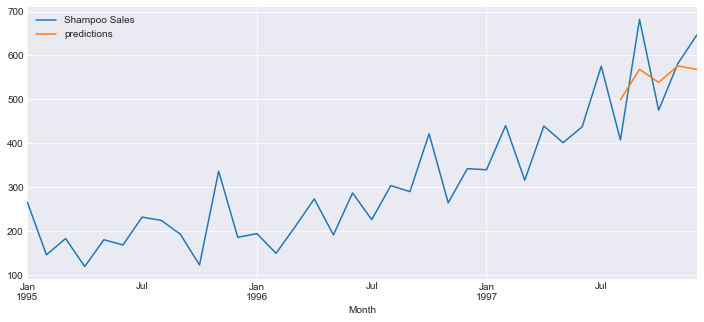

In [30]:
shampoo.plot(figsize = (12, 5))

### Evaluating Results

In [32]:
model.summary()
# const vs ar.L1 (day prior)  
# AIC - to compare models 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Shampoo Sales   No. Observations:                   30
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -169.533
Method:                       css-mle   S.D. of innovations             68.158
Date:                Wed, 28 Apr 2021   AIC                            345.066
Time:                        08:59:18   BIC                            349.269
Sample:                    02-01-1995   HQIC                           346.410
                         - 07-01-1997                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.3532      7.511      1.378      0.168      -4.369      25.075
ar.L1.D.Shampoo Sales    -0.6795      0.141     -4.829      0.000      -0.955      -0.404
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4718           +0.0000j            1.4718            0.5000
-----------------------------------------------------------------------------
"""

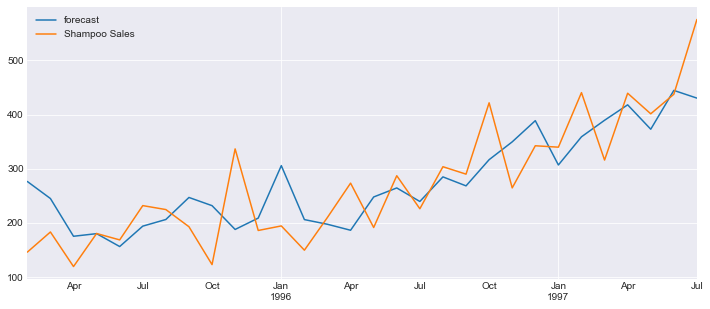

In [33]:
#insample predictions
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
model.plot_predict(ax = ax);

### MSE and RMSE

In [34]:
shampoo.tail()

,Shampoo Sales,predictions
Month,,
1997-08-01,407.6,499.054485
1997-09-01,682.0,568.383754
1997-10-01,475.3,538.665100
1997-11-01,581.3,576.245404
1997-12-01,646.9,568.098855


In [35]:
#keep rows with both observations
error_df = shampoo.dropna()

In [36]:
#add a new error squared column
error_df['squared_error'] = (shampoo['Shampoo Sales'] - shampoo['predictions'])**2

In [37]:
error_df

,Shampoo Sales,predictions,squared_error
Month,,,
1997-08-01,407.6,499.054485,8363.922746
1997-09-01,682.0,568.383754,12908.651288
1997-10-01,475.3,538.665100,4015.135852
1997-11-01,581.3,576.245404,25.548938
1997-12-01,646.9,568.098855,6209.620385


In [38]:
#find mse and rmse
mse = np.mean(error_df['squared_error'])
rmse = np.sqrt(mse)
print(f'The MSE is {mse}\nThe RMSE is {rmse}')

The MSE is 6304.5758418773785
The RMSE is 79.40135919414338


In [39]:
def arima_summary(order_tup):
    ar = ARIMA(train, order=order_tup)
    model = ar.fit()
    #predict 7 days ahead
    forecast = model.forecast(steps = 5)
    #get predictions
    preds = forecast[0]
    res_df = pd.read_excel('data/ShampooSales.xls', index = 'Month')
    fdf = pd.DataFrame(preds, index = res_df.tail().index)
    res_df['predictions'] = fdf
    #keep rows with both observations
    error_df = res_df.tail()
    #compute and print errors
    error_df['squared_error'] = (error_df['Shampoo Sales'] - error_df['predictions'])**2
    mse = np.mean(error_df['squared_error'])
    rmse = np.sqrt(mse)
    print(f'The MSE is {mse}\nThe RMSE is {rmse}')
    res_df.set_index('Month', inplace = True)
    res_df.iloc[-5:, 1] = preds
    res_df.plot(figsize = (15, 5))
    error_df.set_index('Month', inplace = True)
    return error_df

The MSE is 6304.5758418773785
The RMSE is 79.40135919414338


,Shampoo Sales,predictions,squared_error
Month,,,
1997-08-01,407.6,499.054485,8363.922746
1997-09-01,682.0,568.383754,12908.651288
1997-10-01,475.3,538.665100,4015.135852
1997-11-01,581.3,576.245404,25.548938
1997-12-01,646.9,568.098855,6209.620385


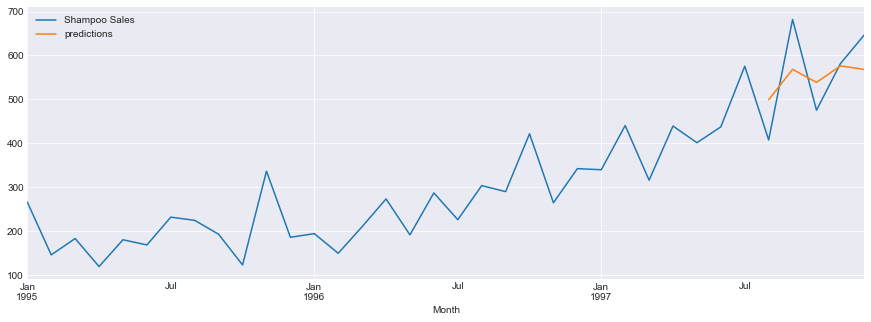

In [40]:
arima_summary((1, 1, 0))

The MSE is 6667.02527169535
The RMSE is 81.65185406159097


,Shampoo Sales,predictions,squared_error
Month,,,
1997-08-01,407.6,474.580669,4486.410004
1997-09-01,682.0,550.744086,17228.115075
1997-10-01,475.3,528.860369,2868.713111
1997-11-01,581.3,552.189353,847.429771
1997-12-01,646.9,557.992979,7904.458398


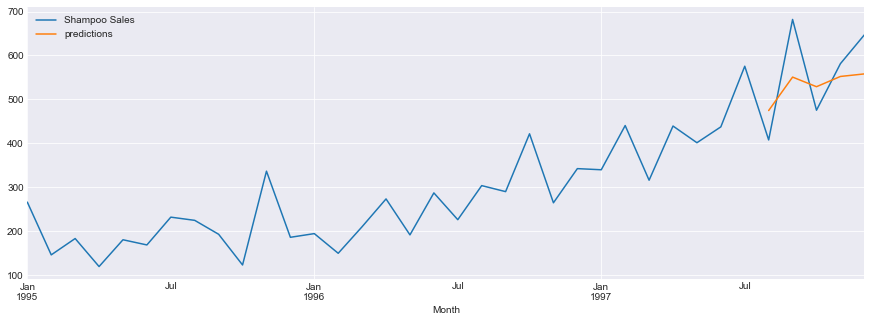

In [41]:
arima_summary((2, 1, 0))

The MSE is 9959.468858066963
The RMSE is 99.79713852644755


,Shampoo Sales,predictions,squared_error
Month,,,
1997-08-01,407.6,472.271247,4182.370172
1997-09-01,682.0,509.263942,29837.745902
1997-10-01,475.3,508.343907,1091.899769
1997-11-01,581.3,557.111473,585.084833
1997-12-01,646.9,528.155553,14100.243614


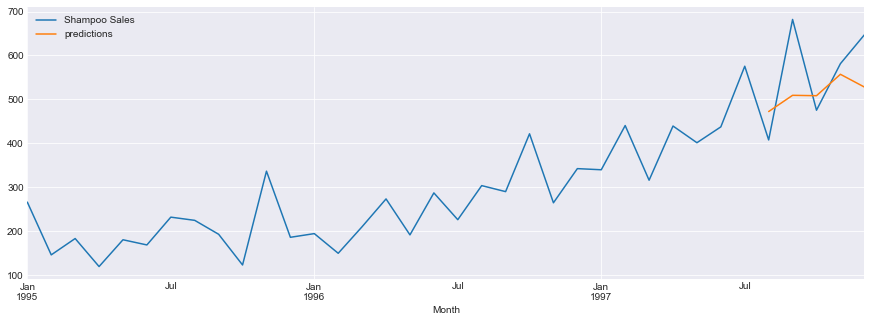

In [42]:
arima_summary((3, 1, 0))